# Data Science & Machine Learning Challenge

Bienvenido al proceso de selección técnica. Este desafío está diseñado para evaluar tus habilidades en ciencia de datos, modelado estadístico y visión de negocio aplicada al sector de retail.

Buscamos identificar:
1. Tu capacidad para estructurar problemas complejos.
2. Generar código de producción.
3. Comunicar hallazgos técnicos a stakeholders de negocio.

## 🎯 Objetivo General
Debes seleccionar uno de los siguientes tres casos de uso y desarrollar una solución "end-to-end". \
Asume el rol de Lead Data Scientist; tu solución debe ser técnicamente sólida y comercialmente viable.

## 📦 Entregables Requeridos
El candidato debe proveer un enlace a un **Repositorio de GitHub público** que incluya:

**1. Código Fuente:**
    * Jupyter Notebooks para análisis exploratorio y experimentación.
    * Scripts modularizados (.py) para el preprocesamiento y entrenamiento final.
    * Se valorará el uso de buenas prácticas de ingeniería de software (typing, docstrings, estructura de carpetas).


**2. Documentación Técnica (README.md):**
    * Instrucciones claras de instalación y ejecución (ej. requirements.txt, environment.yml o Dockerfile).
    * Breve explicación de la arquitectura de la solución.
    * **Debes enviar el link al repositorio público en github.**


**3. Presentación Ejecutiva (PPT, PDF o similares):**
    * Resumen del problema y enfoque metodológico.
    * Resultados del análisis, modelo y métricas de evaluación.
    * Impacto de negocio estimado e interpretación de resultados.
    * Conclusiones y próximos pasos.
    * **Debes enviar la presentación.**

## 📋 Casos de Uso

### 🚚 Caso A: Optimización de Abastecimiento

#### Contexto
Predecir la demanda es solo la mitad de la batalla. Si pedimos menos, perdemos ventas (costo de oportunidad); si pedimos más, incurrimos en costos de almacenamiento y capital.

#### Objetivo
1. Desarrollar un modelo de pronóstico de demanda por SKU-Tienda para la siguiente semana.
2. Diseñar una **función de optimización simple** que determine la cantidad de pedido final, buscando minimizar el costo total esperado (balanceando el costo de Stockout vs. el costo de Overstock).

#### Datos Disponibles

ventas_historicas.csv: fecha, id_tienda, id_producto, unidades_vendidas.\
inventario_actual.csv: id_tienda, id_producto, stock_actual.\
catalogo_productos.csv: id_producto, nombre, costo_unitario, precio_venta, costo_almacenamiento_semanal.\
maestro_tiendas.csv: id_tienda, ciudad, tamaño_m2.

#### Consideraciones Técnicas

El candidato debe proponer cómo usar la incertidumbre del modelo (intervalos de confianza)
junto con los márgenes del producto para decidir si ser agresivo o conservador en el pedido.

In [68]:
%reset -f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy import stats


path = r"C:\Users\ejlop\Downloads\Assesment\data\01_supply_optimization"

In [38]:
file_producto   = '\catalogo_productos.csv'
file_tendencia  = '\ground_truth_trends.csv'
file_inventario = '\inventario_actual.csv'
file_tienda     = '\maestro_tiendas.csv'
file_venta      = '\\ventas_historicas.csv'

df_producto = pd.read_csv(path + file_producto, 
                         sep=',',
                         quotechar="\"",
                         quoting=3,
                         header=0)

df_tendencia   = pd.read_csv(path + file_tendencia, 
                         sep=',',
                         quotechar="\"",
                         quoting=3,
                         header=0)

df_inventario   = pd.read_csv(path + file_inventario, 
                         sep=',',
                         quotechar="\"",
                         quoting=3,
                         header=0)

df_tienda   = pd.read_csv(path + file_tienda, 
                         sep=',',
                         quotechar="\"",
                         quoting=3,
                         header=0,
                         names=["id_tienda", "ciudad", "tamano"])

df_venta   = pd.read_csv(path + file_venta, 
                         sep=',',
                         quotechar="\"",
                         quoting=3,
                         header=0, 
                         parse_dates=["fecha"])

In [39]:
print('********* Ventas *********')
df_venta.info()

print('********* Tiendas *********')
df_tienda.info()

print('********* Inventario *********')
df_inventario.info()

print('********* Tendencia *********')
df_tendencia.info()

print('********* Producto *********')
df_producto.info()

********* Ventas *********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14560 entries, 0 to 14559
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fecha              14560 non-null  datetime64[ns]
 1   id_tienda          14560 non-null  object        
 2   id_producto        14560 non-null  object        
 3   unidades_vendidas  14560 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 455.1+ KB
********* Tiendas *********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_tienda  20 non-null     object
 1   ciudad     20 non-null     object
 2   tamano     20 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 608.0+ bytes
********* Inventario *********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160

## Descriptivas Generales

In [40]:
# Agrupar por semana
venta_semanal = (
    df_venta
    .assign(semana=lambda x: x["fecha"].dt.to_period("W").dt.start_time)
    .groupby(["semana", "id_tienda", "id_producto"])["unidades_vendidas"].sum()
    .add_suffix('').reset_index()
)

df = (
    venta_semanal
    .merge(df_tienda, on="id_tienda", how="left")
    .merge(df_producto, on="id_producto", how="left")
    .merge(df_tendencia, on=["id_producto", "id_tienda"], how="left")
    .merge(df_inventario, on=["id_producto", "id_tienda"], how="left")
)

df["venta"] = df["precio_venta"] * df["unidades_vendidas"]
df["costo_produccion"] =  df["costo_unitario"] * df["unidades_vendidas"] 
df["margen_bruto"] = df["unidades_vendidas"] * (df["precio_venta"] - df["costo_unitario"]) 
df["costo_almacen"] = df["costo_almacenamiento_semanal"] *  df["stock_actual"] 
#df["margen_neto"] = df["unidades_vendidas"] * (df["precio_venta"] - df["costo_unitario"] - df["costo_almacenamiento_semanal"])  
df["margen_neto"] = df["venta"] - df["costo_produccion"] - df["costo_almacen"]  


df['agrupacion'] = 'General'
df['semana'] = pd.to_datetime(df['semana'])


df.head()

,semana,id_tienda,id_producto,unidades_vendidas,ciudad,tamano,nombre,categoria,costo_unitario,precio_venta,costo_almacenamiento_semanal,trend_type,stock_actual,venta,costo_produccion,margen_bruto,costo_almacen,margen_neto,agrupacion
0,2024-01-01,STORE_01,PROD_001,42,Bogotá,28,Tinto,Bebidas,800,2500,10,up,1,105000,33600,71400,10,71390,General
1,2024-01-01,STORE_01,PROD_002,66,Bogotá,28,Café con Leche,Bebidas,1200,3500,15,random,10,231000,79200,151800,150,151650,General
2,2024-01-01,STORE_01,PROD_003,53,Bogotá,28,Cappuccino,Bebidas,1500,4500,15,seasonal,33,238500,79500,159000,495,158505,General
3,2024-01-01,STORE_01,PROD_004,37,Bogotá,28,Pan de Bono,Alimentos,1000,2800,20,up,11,103600,37000,66600,220,66380,General
4,2024-01-01,STORE_01,PROD_005,111,Bogotá,28,Buñuelo,Alimentos,800,2500,20,down,3,277500,88800,188700,60,188640,General


In [41]:
print(f"Tiendas: {df.groupby('ciudad')['id_tienda'].nunique().reset_index()}")
print("--------------- #### ----------------")
print(f"Productos: {df.groupby('categoria')['nombre'].nunique().reset_index()}")

Tiendas:      ciudad  id_tienda
0    Bogotá         14
1      Cali          1
2  Medellín          5
--------------- #### ----------------
Productos:    categoria  nombre
0  Alimentos       4
1    Bebidas       4


In [42]:
#### Fix: Convert columns to numbers before calculating metrics
cols_to_convert = ["precio_venta", "costo_unitario", "costo_almacenamiento_semanal", "unidades_vendidas"]

for col in cols_to_convert:
    # errors='coerce' turns non-numeric text into NaN to prevent further crashes
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Now your aggregation will work without the TypeError
product_metrics = (
    df
    .groupby(["agrupacion"])
    .agg(
        total_venta = ("venta", "sum"),
        unidades_vendidas = ("unidades_vendidas", "sum"),
        costos_producir = ("costo_produccion", "sum"),
        margen_bruto = ("margen_bruto", "sum"),
        costo_almacenamiento = ("costo_almacen", "sum"),
        margen_neto = ("margen_neto", "sum"),
        prom_semanal_demanda =("unidades_vendidas", "mean")
    ).reset_index()
)

product_metrics["porc_margen_bruto"] = product_metrics["margen_bruto"] / product_metrics["total_venta"]
product_metrics["porc_margen_neto"] = product_metrics["margen_neto"] / product_metrics["total_venta"]

top_products = (
    product_metrics
    .sort_values("total_venta", ascending=False)
    .reset_index(drop=True)
)


print(top_products.head(20))

  agrupacion  total_venta  unidades_vendidas  costos_producir  margen_bruto  \
0    General    681389500             191861        248456000     432933500   

   costo_almacenamiento  margen_neto  prom_semanal_demanda  porc_margen_bruto  \
0               1023425    431910075             92.240865           0.635369   

   porc_margen_neto  
0          0.633867  


In [43]:
#### Fix: Convert columns to numbers before calculating metrics
cols_to_convert = ["precio_venta", "costo_unitario", "costo_almacenamiento_semanal", "unidades_vendidas"]

for col in cols_to_convert:
    # errors='coerce' turns non-numeric text into NaN to prevent further crashes
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Now your aggregation will work without the TypeError
product_metrics = (
    df
    .groupby(["id_producto", "nombre"])
    .agg(
        total_venta = ("venta", "sum"),
        unidades_vendidas = ("unidades_vendidas", "sum"),
        costos_producir = ("costo_produccion", "sum"),
        margen_bruto = ("margen_bruto", "sum"),
        costo_almacenamiento = ("costo_almacen", "sum"),
        margen_neto = ("margen_neto", "sum"),
        prom_semanal_demanda =("unidades_vendidas", "mean")
    ).reset_index()
)

product_metrics["porc_margen_bruto"] = product_metrics["margen_bruto"] / product_metrics["total_venta"]
product_metrics["porc_margen_neto"] = product_metrics["margen_neto"] / product_metrics["total_venta"]

product_metrics["porc_marg_venta"] = product_metrics["total_venta"] / product_metrics["total_venta"].sum()
product_metrics["porc_marg_unid_venta"] = product_metrics["unidades_vendidas"] / product_metrics["unidades_vendidas"].sum()
product_metrics["porc_marg_mbruto"] = product_metrics["margen_bruto"] / product_metrics["margen_bruto"].sum()
product_metrics["porc_marg_mneto"] = product_metrics["margen_neto"] / product_metrics["margen_neto"].sum()
product_metrics["porc_marg_calmacen"] = product_metrics["costo_almacenamiento"] / product_metrics["costo_almacenamiento"].sum()


top_products = (
    product_metrics
    .sort_values("unidades_vendidas", ascending=False)
    .reset_index(drop=True)
)

top_products[[
    "nombre",
    "total_venta",
    "porc_marg_venta",
    "unidades_vendidas",
    "porc_marg_unid_venta",
    "margen_bruto",
    "porc_margen_bruto",
    "costo_almacenamiento",
    "porc_marg_calmacen",
    "prom_semanal_demanda"
]]

,nombre,total_venta,porc_marg_venta,unidades_vendidas,porc_marg_unid_venta,margen_bruto,porc_margen_bruto,costo_almacenamiento,porc_marg_calmacen,prom_semanal_demanda
0,Buñuelo,81222500,0.119201,32489,0.169336,55231300,0.680000,102180,0.099841,124.957692
1,Pastel de Pollo,110141500,0.161642,31469,0.164020,62938000,0.571429,137670,0.134519,121.034615
2,Jugo de Naranja,149165000,0.218913,29833,0.155493,89499000,0.600000,300300,0.293426,114.742308
3,Croissant,101132500,0.148421,28895,0.150604,66458500,0.657143,147225,0.143855,111.134615
4,Cappuccino,95620500,0.140332,21249,0.110752,63747000,0.666667,84825,0.082883,81.726923
5,Café con Leche,72030000,0.105710,20580,0.107265,47334000,0.657143,68445,0.066878,79.153846
6,Tinto,37427500,0.054928,14971,0.078030,25450700,0.680000,56420,0.055129,57.580769
7,Pan de Bono,34650000,0.050852,12375,0.064500,22275000,0.642857,126360,0.123468,47.596154


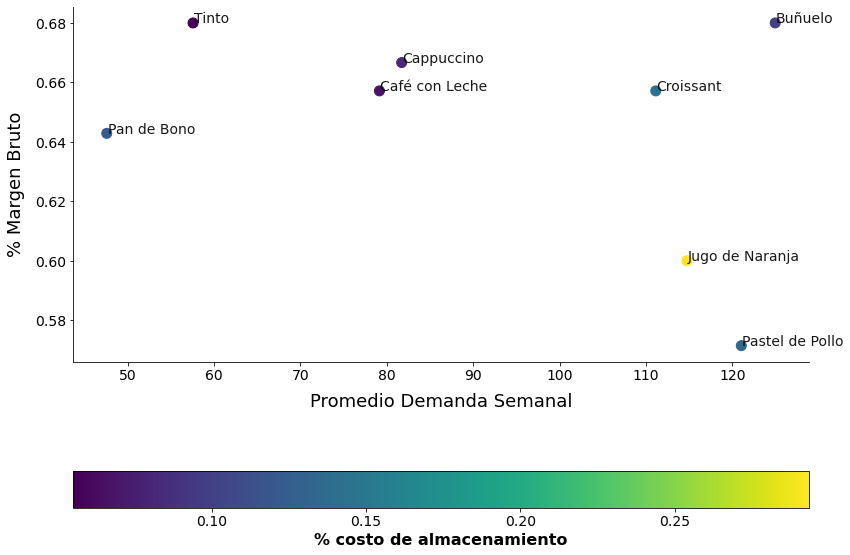

In [49]:
# 1. Create the base scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    data=top_products,
    x='prom_semanal_demanda',
    y='porc_margen_bruto',
    c='porc_marg_calmacen',
    cmap='viridis',
    s=100
)

# 2. Add horizontal colorbar with the NEW label [% costo de almacenamiento]
cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.2)
# Updated label text here:
cbar.set_label('% costo de almacenamiento', fontsize=16, fontweight='bold') 
cbar.ax.tick_params(labelsize=14)

# 3. Add point labels with large size
for i in range(len(top_products)):
    plt.text(
        x=top_products['prom_semanal_demanda'].iloc[i] + 0.1,
        y=top_products['porc_margen_bruto'].iloc[i],
        s=top_products['nombre'].iloc[i],
        fontsize=14,
        fontweight='medium',
        alpha=0.9
    )

# 4. Remove top and right lines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 5. Axis and Title font sizes
plt.xlabel('Promedio Demanda Semanal', fontsize=18, labelpad=10)
plt.ylabel('% Margen Bruto', fontsize=18, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('Análisis de Margen vs Demanda', fontsize=22, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

In [50]:
# Corrected nested np.where logic
df['segmento'] = np.where(
    (df['nombre'] == 'Pastel de Pollo') | (df['nombre'] == 'Jugo de Naranja'), 
    'Demanda_alta_margen_medio',
    np.where(
        (df['nombre'] == 'Croissant') | (df['nombre'] == 'Buñuelo'), 
        'Demanda_alta_margen_alto',
        np.where(
            (df['nombre'] == 'Cappuccino') | (df['nombre'] == 'Café con Leche'), 
            'Demanda_media_margen_alto',
            np.where(
                (df['nombre'] == 'Tinto') | (df['nombre'] == 'Pan de Bono'), 
                'Demanda_baja_margen_alto',
                'Otro' # Replaces the dangling 'None'
            )
        )
    )
)

df.groupby(["nombre", "segmento"]).agg(unidades_vendidas = ("unidades_vendidas", "sum")).reset_index()
    

,nombre,segmento,unidades_vendidas
0,Buñuelo,Demanda_alta_margen_alto,32489
1,Café con Leche,Demanda_media_margen_alto,20580
2,Cappuccino,Demanda_media_margen_alto,21249
3,Croissant,Demanda_alta_margen_alto,28895
4,Jugo de Naranja,Demanda_alta_margen_medio,29833
5,Pan de Bono,Demanda_baja_margen_alto,12375
6,Pastel de Pollo,Demanda_alta_margen_medio,31469
7,Tinto,Demanda_baja_margen_alto,14971


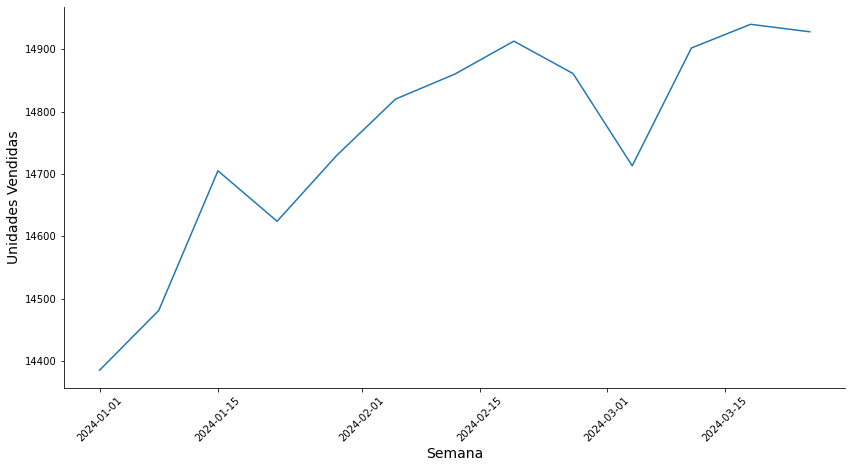

In [59]:
# Now your aggregation will work without the TypeError
venta_unidad_gral = (
    df
    .groupby(["semana", "agrupacion"])
    .agg(unidades_vendidas = ("unidades_vendidas", "sum"))
    .reset_index()
)

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=venta_unidad_gral, 
    x="semana", 
    y="unidades_vendidas", 
    estimator="sum",  # Sums units sold across all stores/products per week
    ci=None           # Removes the confidence interval shading for clarity
)

# 4. Remove top and right lines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 4. Customization
#plt.title("Total Unidades Vendidas por Semana", fontsize=15)
plt.xlabel("Semana", fontsize=14)
plt.ylabel("Unidades Vendidas", fontsize=14)
plt.xticks(rotation=45)

plt.show()

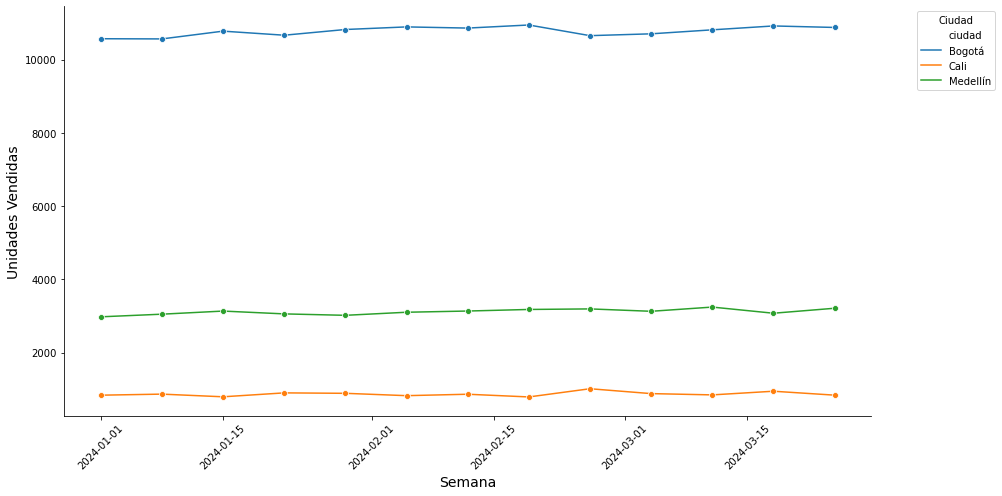

In [58]:
# Now your aggregation will work without the TypeError
venta_unidad_ciudad = (
    df
    .groupby(["semana", "ciudad"])
    .agg(unidades_vendidas = ("unidades_vendidas", "sum"))
    .reset_index()
)

# 3. Create the line plot broken down by city
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=venta_unidad_ciudad, 
    x="semana", 
    y="unidades_vendidas", 
    hue="ciudad",      # This creates a different line for each city
    estimator="sum",   # Aggregates units sold per city per week
    ci=None,           # Removes the shadow for a cleaner look
    marker='o'        # Adds points on the lines for better readability
)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 4. Customization and Labels
#plt.title("Evolución de Unidades Vendidas por Ciudad", fontsize=16)
plt.xlabel("Semana", fontsize=14)
plt.ylabel("Unidades Vendidas", fontsize=14)
plt.legend(title="Ciudad", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# In your local environment, use plt.show()
plt.show()

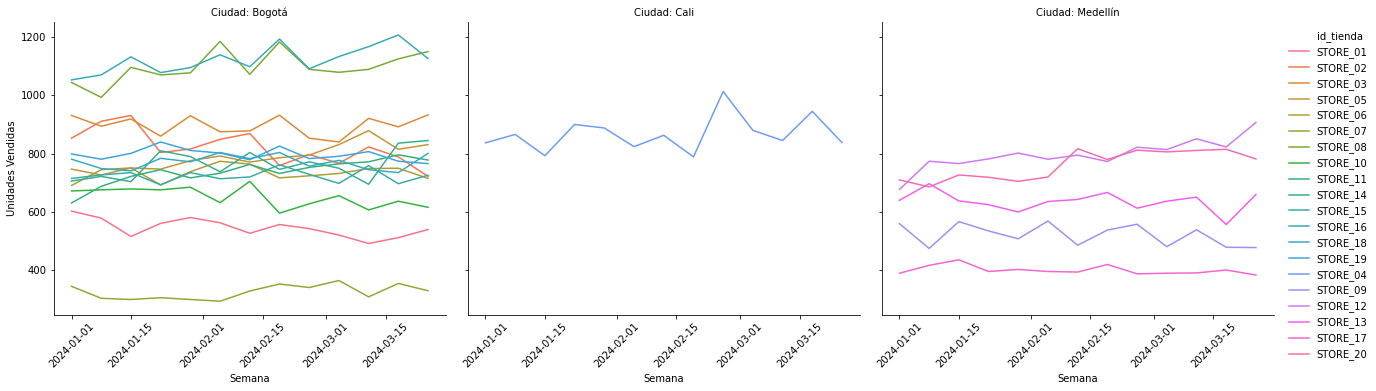

In [15]:
# Now your aggregation will work without the TypeError
venta_unidad_tienda = (
    df
    .groupby(["semana", "ciudad", "id_tienda"])
    .agg(unidades_vendidas = ("unidades_vendidas", "sum"))
    .reset_index()
)


# Faceted view: Each city gets its own subplot column
g = sns.relplot(
    data=venta_unidad_tienda, 
    x="semana", 
    y="unidades_vendidas", 
    hue="id_tienda", 
    col="ciudad",      # Creates a subplot for each city
    kind="line", 
    estimator="sum", 
    ci=None, 
    markers=True,
    height=5, 
    aspect=1.2
)

g.set_axis_labels("Semana", "Unidades Vendidas")
g.set_titles("Ciudad: {col_name}")

for ax in g.axes.flat:
    ax.tick_params(axis='x', labelrotation=45)
    
plt.show()

In [ ]:
# Faceted view: Each city gets its own subplot column
g = sns.relplot(
    data=df, 
    x="semana", 
    y="unidades_vendidas", 
    hue="categoria", 
    col="ciudad",      # Creates a subplot for each city
    kind="line", 
    estimator="sum", 
    ci=None, 
    markers=True,
    height=5, 
    aspect=1.2
)

g.set_axis_labels("Semana", "Unidades Vendidas")
g.set_titles("Ciudad: {col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelrotation=45)
plt.show()

In [ ]:
# Faceted view: Each city gets its own subplot column
g = sns.relplot(
    data=df, 
    x="semana", 
    y="unidades_vendidas", 
    hue="nombre", 
    col="ciudad",      # Creates a subplot for each city
    kind="line", 
    estimator="sum", 
    ci=None, 
    markers=True,
    height=5, 
    aspect=1.2
)

g.set_axis_labels("Semana", "Unidades Vendidas")
g.set_titles("Ciudad: {col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelrotation=45)
plt.show()

In [ ]:
# 2. Use relplot with col_wrap=3
g = sns.relplot(
    data=df,
    x="semana",
    y="unidades_vendidas",
    hue="nombre",      # Different colors for each product
    col="id_tienda",   # Create a subplot for each store
    col_wrap=4,        # <--- THIS LIMITS THE GRID TO 3 COLUMNS
    kind="line",
    estimator="sum",   # Aggregates units if there are multiple daily entries
    ci=None,           # Removes the confidence interval shading
    markers=True,      # Adds dots at each data point
    height=4,          # Adjusts individual subplot height
    aspect=1.2         # Adjusts individual subplot width
)

# 3. Customization
g.set_axis_labels("Semana", "Unidades Vendidas")
g.set_titles("Tienda: {col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelrotation=45)
plt.show()

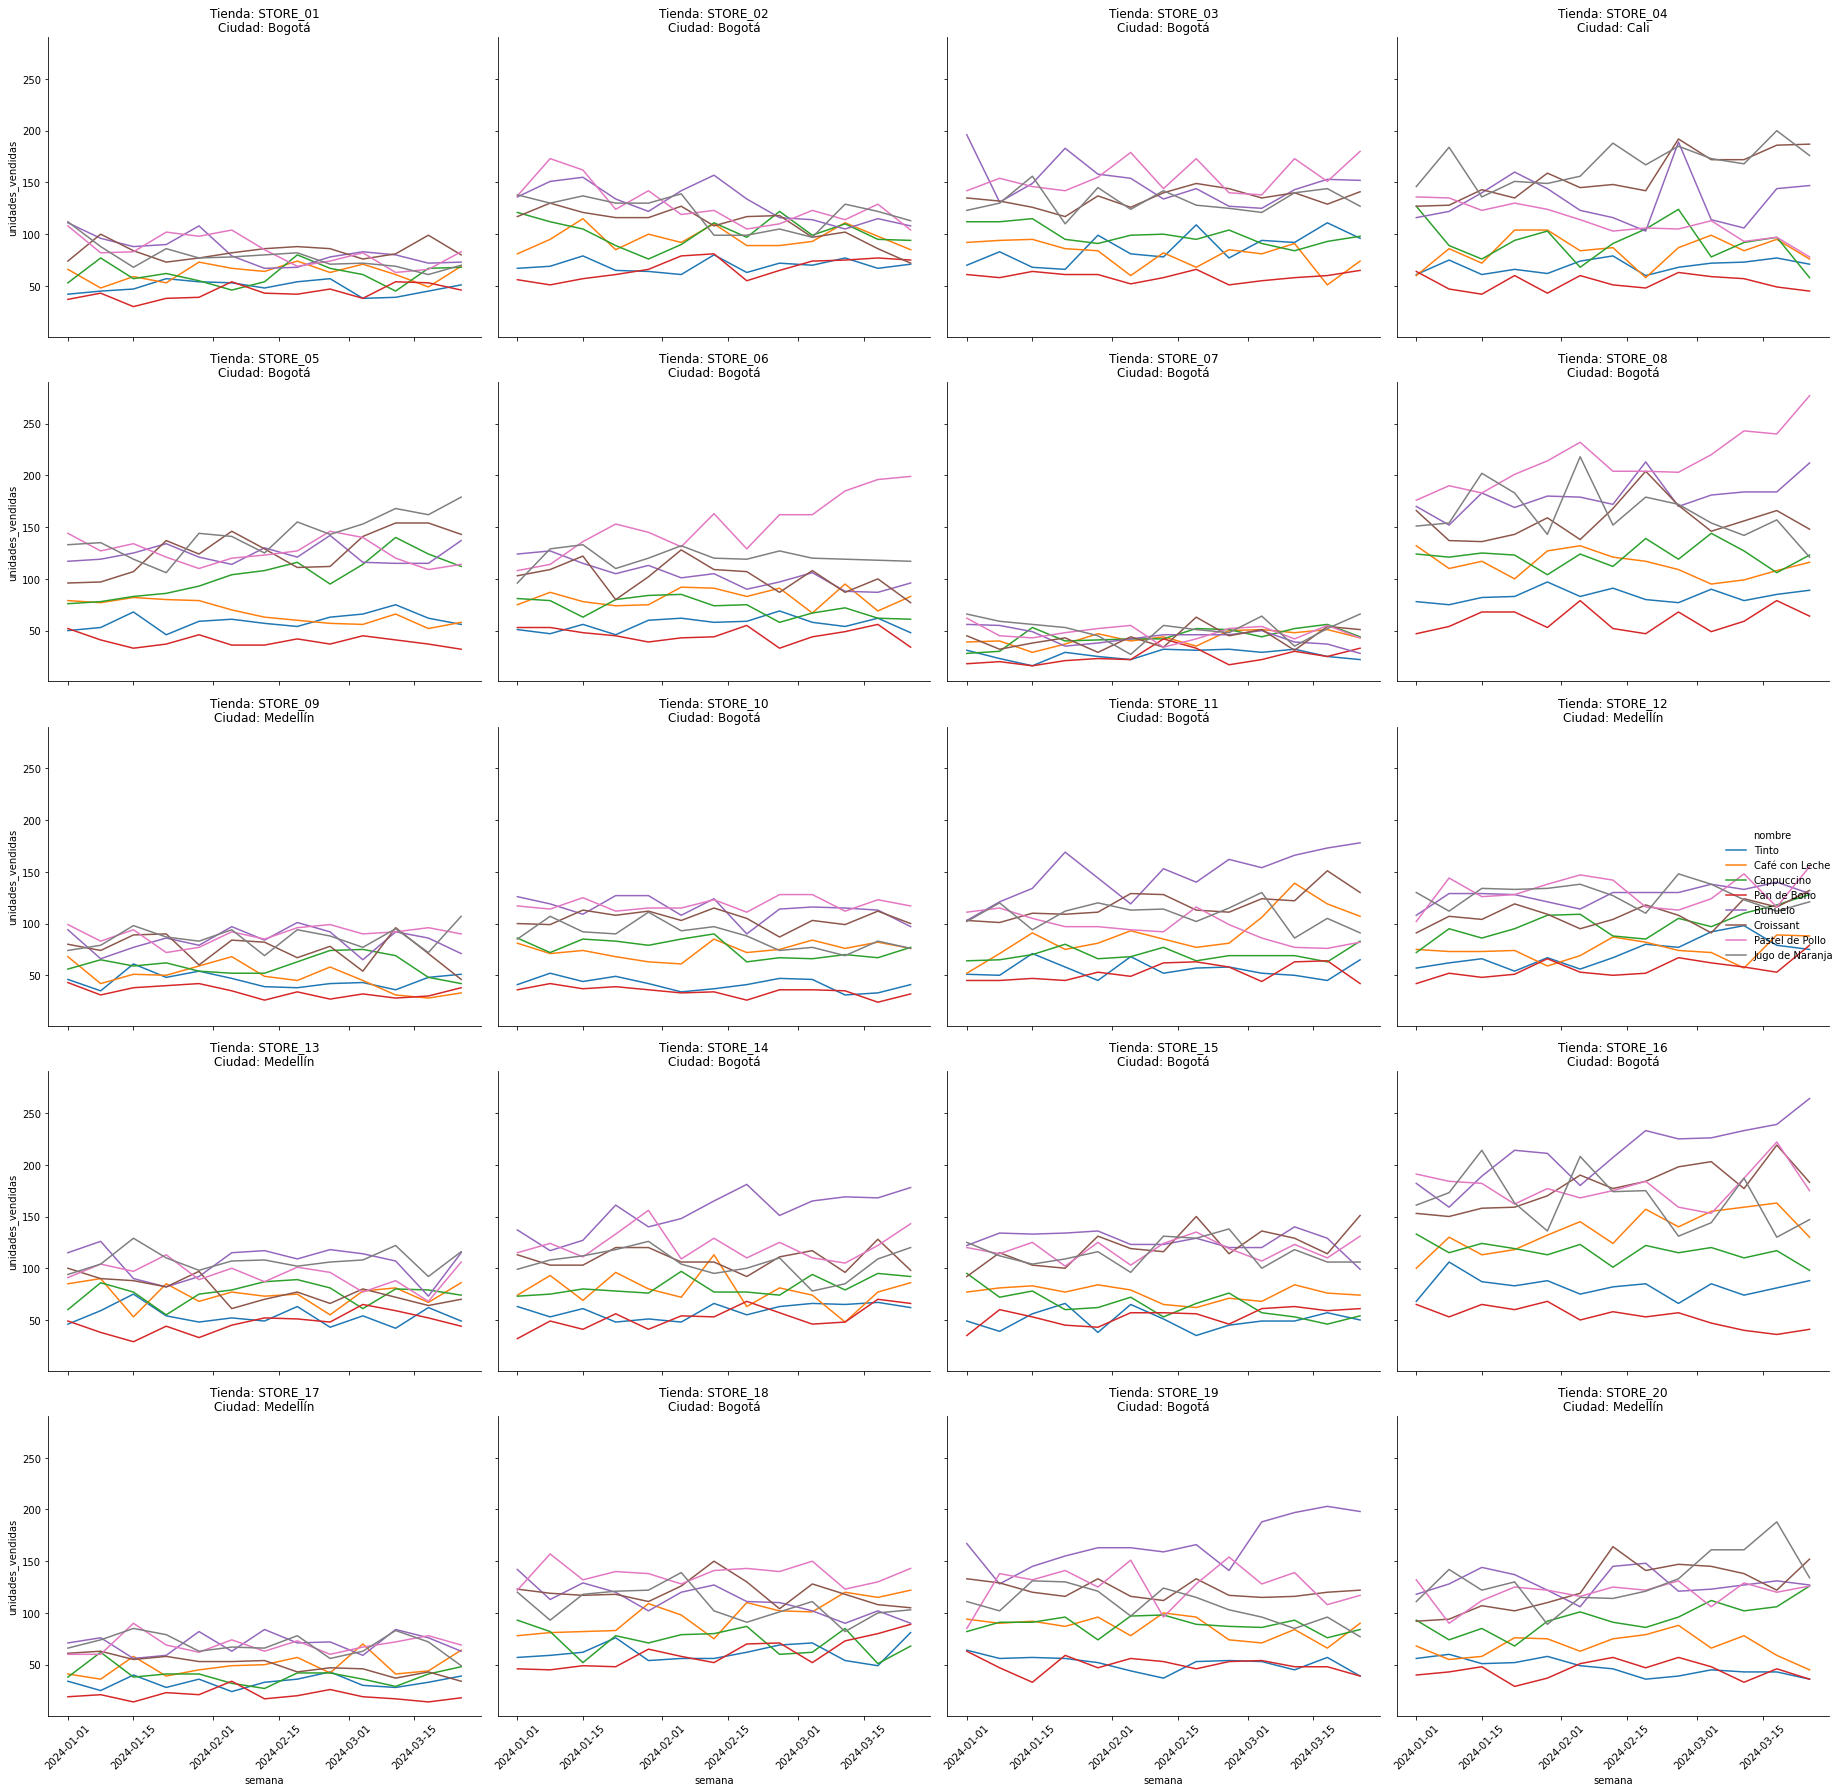

In [16]:
# 1. Ensure 'ciudad' is included in your groupby if aggregating, 
# or present in the dataframe
# We use col="id_tienda" to keep the store-level view
g = sns.relplot(
    data=df, 
    x="semana", 
    y="unidades_vendidas",
    hue="nombre",      # Color by Product Name
    col="id_tienda",   # One subplot per store
    col_wrap=4,        # Clean 3-column grid
    kind="line", 
    estimator="sum", 
    ci=None, 
    markers=True, 
    height=5, 
    aspect=1.2
)

# 2. FIX: Map titles to show both Store ID and City
# This requires a dictionary mapping id_tienda to ciudad if not directly in the facet
tienda_ciudad_map = df.set_index('id_tienda')['ciudad'].to_dict()

for ax in g.axes.flat:
    store_id = ax.get_title().split('= ')[-1] # Extracts the ID from the default title
    if store_id in tienda_ciudad_map:
        city_name = tienda_ciudad_map[store_id]
        ax.set_title(f"Tienda: {store_id}\nCiudad: {city_name}") # Includes Ciudad in label

# 3. Apply the 45 degree rotation to all x-axis labels
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

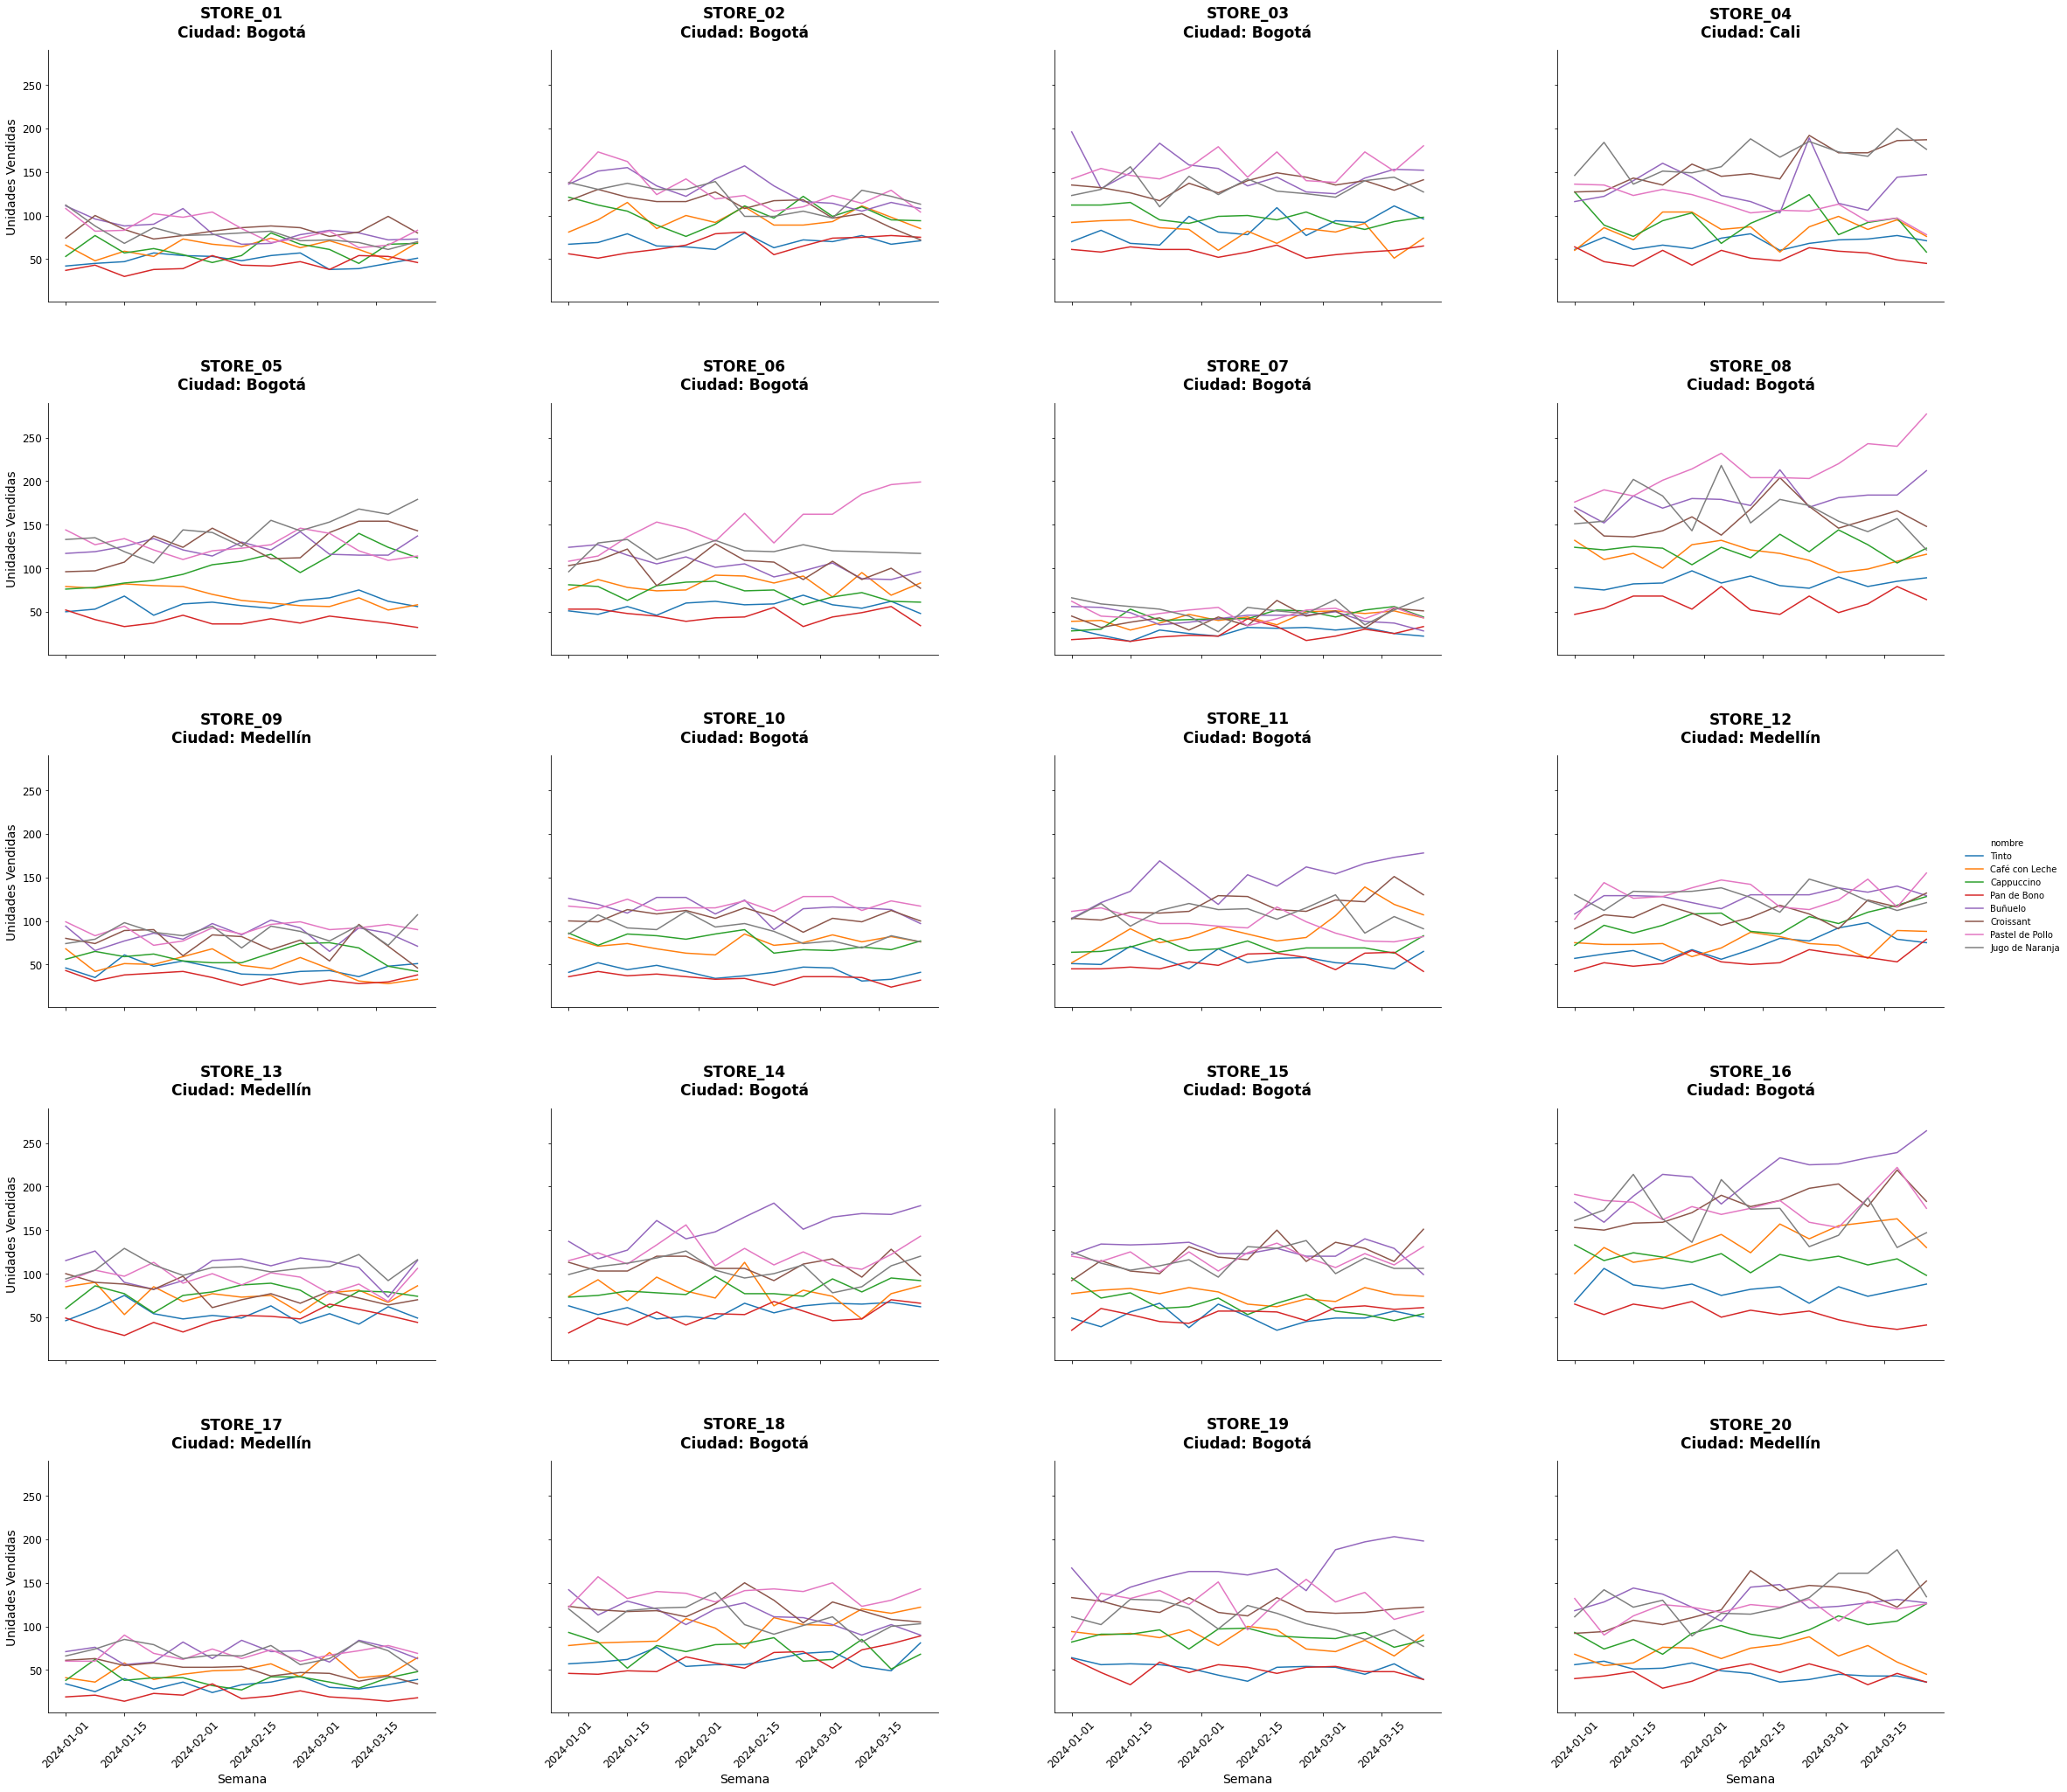

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create the FacetGrid with increased scale
g = sns.relplot(
    data=df, 
    x="semana", 
    y="unidades_vendidas",
    hue="nombre",      
    col="id_tienda",   
    col_wrap=4,        
    kind="line", 
    estimator="sum", 
    ci=None, 
    markers=True, 
    height=6,          # Increased height per facet for better distribution
    aspect=1.3         # Slightly wider facets
)

# 2. Map titles with larger fonts
tienda_ciudad_map = df.set_index('id_tienda')['ciudad'].to_dict()

for ax in g.axes.flat:
    store_id = ax.get_title().split('= ')[-1]
    if store_id in tienda_ciudad_map:
        city_name = tienda_ciudad_map[store_id]
        # Larger font for individual store titles
        ax.set_title(f"{store_id}\nCiudad: {city_name}", fontsize=17, fontweight='bold', pad=15)

# 3. Apply rotation and larger labels to all axes
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelrotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlabel("Semana", fontsize=14)
    ax.set_ylabel("Unidades Vendidas", fontsize=14)

# 4. HUGE MAIN TITLE AND DISTRIBUTION ADJUSTMENT
# subplots_adjust is key to preventing the big title from overlapping facets
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3) 

#g.fig.suptitle('Evolución de Ventas Semanales por Tienda y Ciudad', 
#               fontsize=32, 
#               fontweight='bold', 
#               y=1.05) # Positioned high above the grid

plt.show()

In [ ]:
# 2. Use relplot with col_wrap=3
g = sns.relplot(
    data=df,
    x="semana",
    y="unidades_vendidas",
    hue="id_tienda",      # Different colors for each product
    col="nombre",   # Create a subplot for each store
    col_wrap=4,        # <--- THIS LIMITS THE GRID TO 3 COLUMNS
    kind="line",
    estimator="sum",   # Aggregates units if there are multiple daily entries
    ci=None,           # Removes the confidence interval shading
    markers=True,      # Adds dots at each data point
    height=4,          # Adjusts individual subplot height
    aspect=1.2         # Adjusts individual subplot width
)

# 3. Customization
g.set_axis_labels("Semana", "Unidades Vendidas")
g.set_titles("Nombre: {col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelrotation=45)
plt.show()

In [17]:
# Now your aggregation will work without the TypeError
venta_tienda_sku = (
    df
    .groupby(["semana", "ciudad", "id_tienda", 'nombre'])
    .agg(unidades_vendidas = ("unidades_vendidas", "sum"))
    .reset_index()
)

# 2. Filter out zeros, NaNs, and empty values
# .notna() handles NaNs, and > 0 handles zeros/empty numeric slots
filtered_df = df[df['unidades_vendidas'].notna() & (df['unidades_vendidas'] > 0)]

# 3. Group and Count
valid_counts = (
    df
    .groupby(['ciudad', 'id_tienda', 'nombre'])
    .agg(conteo_valido=('semana', 'count'))
    .reset_index()
)

# 4. Display results
valid_counts[valid_counts["conteo_valido"] == 13]



,ciudad,id_tienda,nombre,conteo_valido
0,Bogotá,STORE_01,Buñuelo,13
1,Bogotá,STORE_01,Café con Leche,13
2,Bogotá,STORE_01,Cappuccino,13
3,Bogotá,STORE_01,Croissant,13
4,Bogotá,STORE_01,Jugo de Naranja,13
...,...,...,...,...
155,Medellín,STORE_20,Croissant,13
156,Medellín,STORE_20,Jugo de Naranja,13
157,Medellín,STORE_20,Pan de Bono,13
158,Medellín,STORE_20,Pastel de Pollo,13


In [ ]:
# Aggregate all sales to get a single weekly value
#series = venta_unidad_gral.asfreq('W-MON')

series = (
    df
    .groupby(["semana"])
    .agg(unidades_vendidas = ("unidades_vendidas", "sum"))
    .asfreq('W-MON')
)

#series = df.groupby('semana')['unidades_vendidas'].sum().asfreq('W-MON')

# 2. Fit with adjusted parameters to avoid broadcasting errors
# 'seasonal_periods' must be smaller than the total length of your data
model = ExponentialSmoothing(
    series, 
    trend='add', 
    seasonal='add', 
    seasonal_periods=4  # Use 4 if you have limited weeks (monthly pattern)
).fit()

# 3. Forecast and Plot
forecast = model.forecast(12)
plt.figure(figsize=(10, 5))
plt.plot(series, label="Histórico")
plt.plot(forecast, label="Pronóstico", color='red', linestyle='--')
plt.legend()
plt.show()

C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


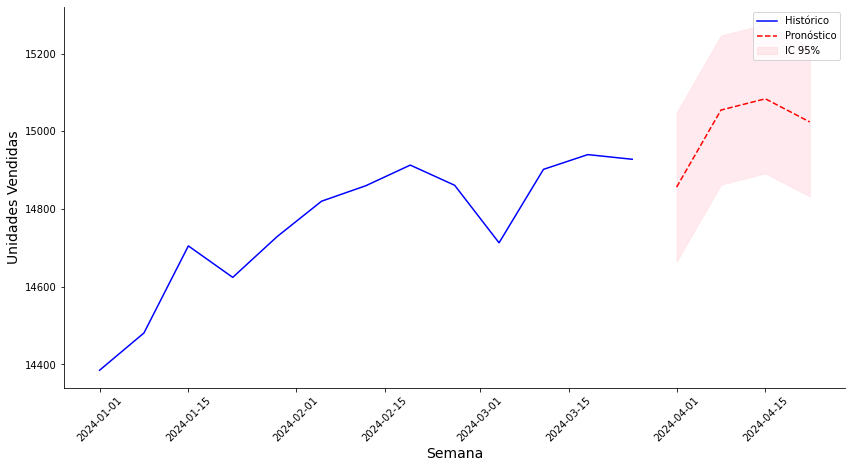

In [67]:
series = (
    df
    .groupby(["semana"])
    .agg(unidades_vendidas = ("unidades_vendidas", "sum"))
    .asfreq('W-MON')
)

# 1. Fit Holt-Winters
model = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=4).fit()

# 2. Forecast exactly 12 weeks
forecast_steps = 4
forecast = model.forecast(forecast_steps)

# 3. Calculate Confidence Intervals based ONLY on the forecast length
# residuals has length 26, but 'forecast' has length 12
residuals = series['unidades_vendidas'] - model.fittedvalues
sigma = residuals.std()
z_score = 1.96

# These bounds will now have a shape of (12,) to match the forecast
lower_bound = forecast - (z_score * sigma)
upper_bound = forecast + (z_score * sigma)

# 4. Plotting
plt.figure(figsize=(14, 7))
plt.plot(series, label="Histórico", color="blue")
plt.plot(forecast, label="Pronóstico", color="red", linestyle="--")

# FIX: Ensure all three inputs have shape (12,)
plt.fill_between(forecast.index, lower_bound, upper_bound, color='pink', alpha=0.3, label="IC 95%")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(rotation=45)
plt.xlabel("Semana", fontsize=14)
plt.ylabel("Unidades Vendidas", fontsize=14)
#plt.title("Holt-Winters Forecast con Intervalos de Confianza")
plt.legend()
plt.show()

In [30]:
# Combine results into one DataFrame
df_combined = pd.concat([lower_bound, forecast, upper_bound], axis=1)

# Fix the AttributeError by using the correct property
df_combined.columns = ["LI", "Forecast", "LS"] 

print(df_combined.head())

                      LI      Forecast            LS
2024-04-01  14664.660053  14856.375115  15048.090177
2024-04-08  14862.958664  15054.673726  15246.388788
2024-04-15  14891.894036  15083.609098  15275.324160
2024-04-22  14832.359036  15024.074098  15215.789160


In [31]:
# 1. Prepare continuous time series
series = df.groupby('semana')['unidades_vendidas'].sum().asfreq('W-MON').fillna(0)
train = series.iloc[:-4]
test = series.iloc[-4:]

# 2. Fit and Forecast
model_fit = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=4).fit()
y_pred = model_fit.forecast(len(test))
y_true = test

# 3. Manual Metric Calculation
mae = mean_absolute_error(y_true, y_pred)
# Calculate MAPE manually to avoid the ImportError
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"Holt-Winters MAE: {mae:.2f} units")
print(f"Holt-Winters MAPE: {mape:.2f}%")

Holt-Winters MAE: 198.78 units
Holt-Winters MAPE: 1.34%


C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


In [32]:
all_forecasts = []

# 2. Iterate through each Store and Product combination
grouped = df.groupby(['id_tienda', 'nombre'])

for (tienda, producto), group in grouped:
    # Set 'semana' as index and ensure weekly frequency
    series = group.set_index('semana')['unidades_vendidas'].asfreq('W-MON').fillna(0)
    
    # Only forecast if we have enough data points (e.g., at least 8 weeks)
    if len(series) > 8:
        try:
            # Fit Holt-Winters model
            # Using 4 for seasonal_periods if data history is short
            model = ExponentialSmoothing(
                series, trend='add', seasonal='add', seasonal_periods=4 
            ).fit()
            
            # Forecast next 4 weeks
            forecast_values = model.forecast(4)
            
            # Calculate Standard Deviation of Residuals
            residuals = series - model.fittedvalues
            sigma = residuals.std()
            
            # Save results
            for date, val in forecast_values.items():
                all_forecasts.append({
                    'semana': date,
                    'id_tienda': tienda,
                    'nombre': producto,
                    'unidades_pronosticadas': round(val, 2),
                    'IC_inf_95': round(val - (1.96 * sigma), 2),
                    'IC_sup_95': round(val + (1.96 * sigma), 2)
                })
        except:
            # Skip groups where the model fails to converge
            continue

# 3. Create a final forecast table
df_forecast = pd.DataFrame(all_forecasts)
print(df_forecast.head())

C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
C:\Users\ejlop\anaconda3\lib\site-packag

      semana id_tienda          nombre  unidades_pronosticadas  IC_inf_95  \
0 2024-04-01  STORE_01         Buñuelo                   56.32      36.76   
1 2024-04-08  STORE_01         Buñuelo                   46.64      27.07   
2 2024-04-15  STORE_01         Buñuelo                   46.96      27.39   
3 2024-04-22  STORE_01         Buñuelo                   66.28      46.71   
4 2024-04-01  STORE_01  Café con Leche                   55.39      35.30   

   IC_sup_95  
0      75.89  
1      66.21  
2      66.53  
3      85.85  
4      75.48  


C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


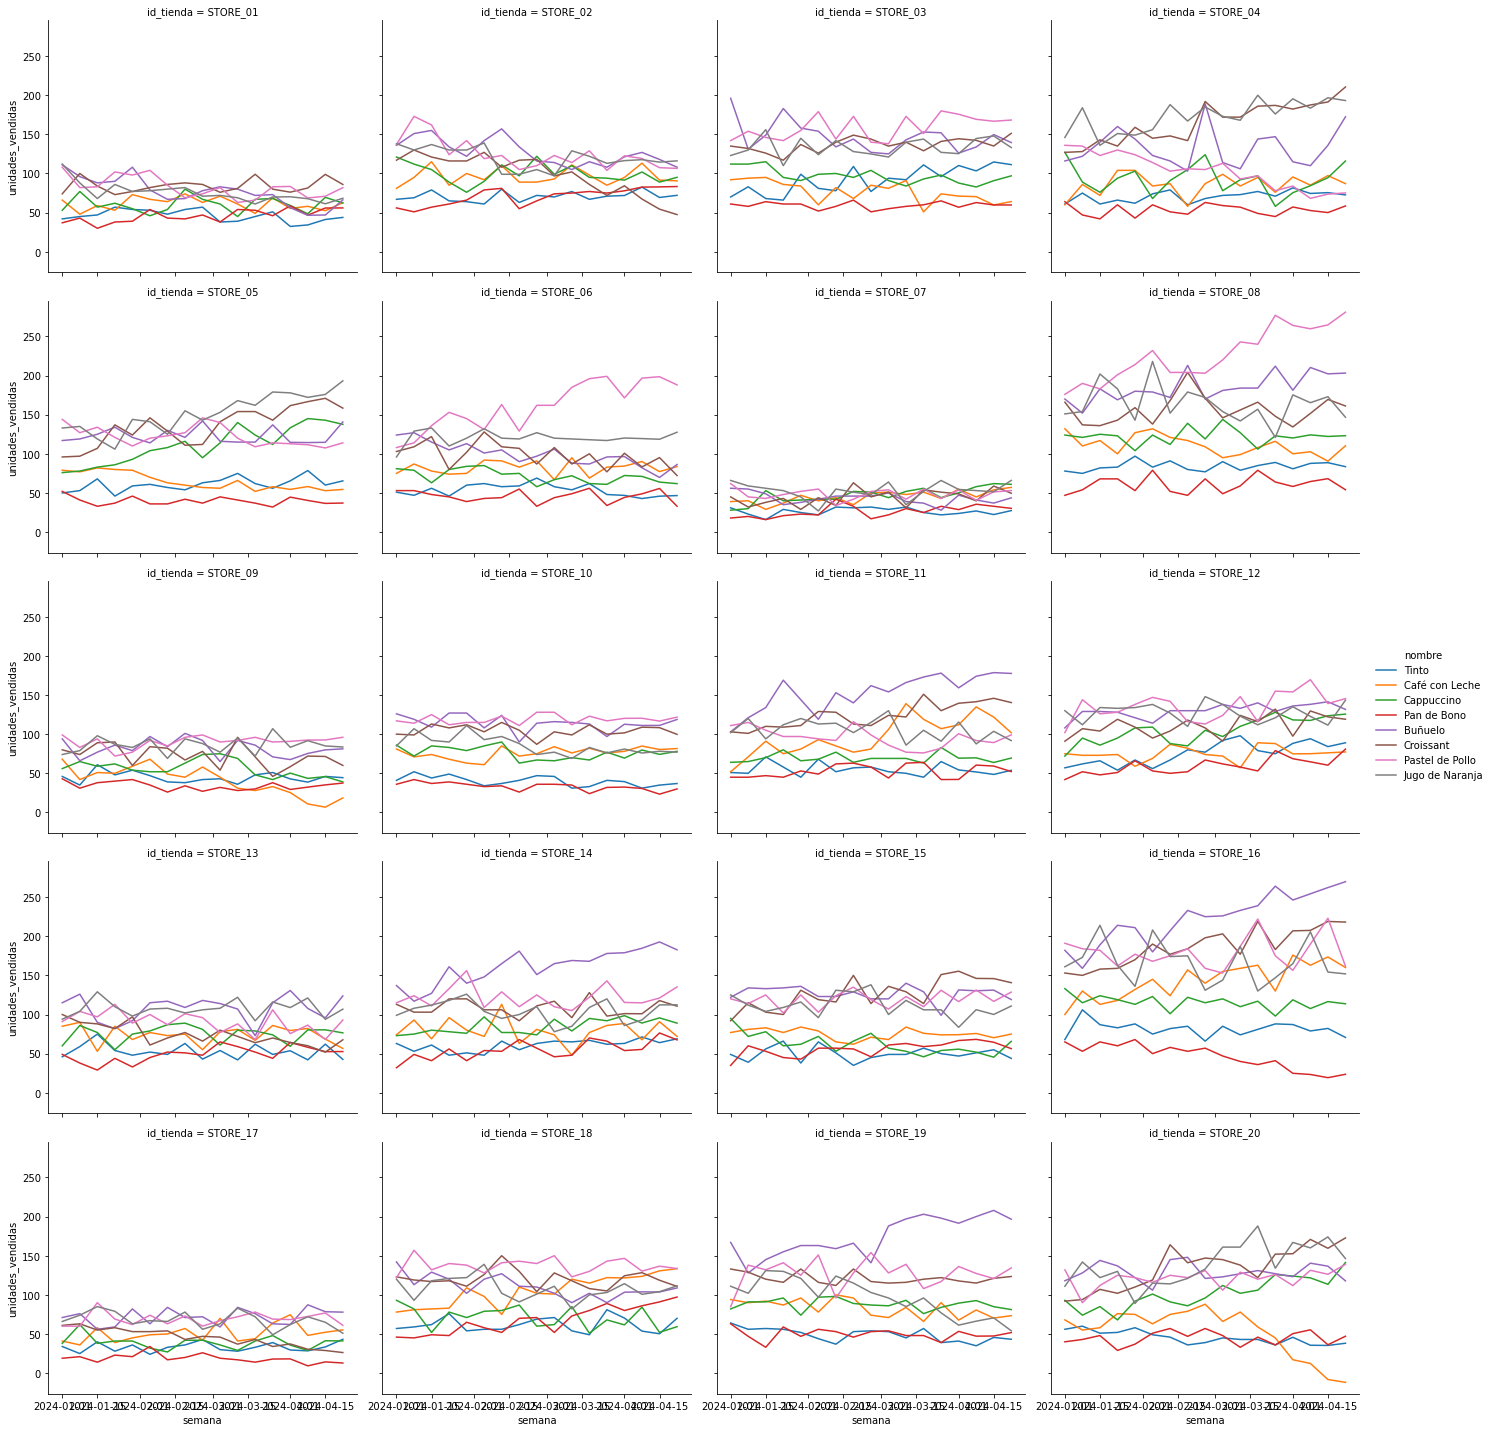

In [33]:
# Combine historic and forecast data for plotting
df_plot = pd.concat([df, df_forecast.rename(columns={'unidades_pronosticadas': 'unidades_vendidas'})])

g = sns.relplot(
    data=df_plot, x="semana", y="unidades_vendidas",
    hue="nombre", col="id_tienda", col_wrap=4, 
    kind="line", markers=True, height=4, aspect=1.2
)
plt.show()

In [34]:
# 1. Custom MAPE function to fix the ImportError
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Filter out zeros to avoid division by zero errors
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# 2. Data Preparation
df['semana'] = pd.to_datetime(df['semana'])
results_list = []

# 3. Iterate through each Store and Product
grouped = df.groupby(['id_tienda', 'nombre'])

for (tienda, producto), group in grouped:
    # Set frequency and fill gaps to avoid broadcasting errors
    series = group.set_index('semana')['unidades_vendidas'].asfreq('W-MON').fillna(0)
    
    if len(series) > 8:  # Ensure enough data for training/testing
        train = series.iloc[:-4]
        test = series.iloc[-4:]
        
        try:
            # Fit Holt-Winters
            model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=4).fit()
            y_pred = model.forecast(len(test))
            
            # Calculate metrics
            mae = mean_absolute_error(test, y_pred)
            mape = calculate_mape(test, y_pred)
            
            results_list.append({
                'id_tienda': tienda,
                'nombre_producto': producto,
                'MAE': round(mae, 2),
                'MAPE': round(mape, 5),
                'MAPE_P': f"{round(mape, 2)}%",
                
            })
        except:
            continue

# 4. Create the final Accuracy Table
df_accuracy = pd.DataFrame(results_list)
print(df_accuracy.sort_values(by='MAPE', ascending=False).head(50))

C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\ejlop\anaconda3\lib\site-pac

    id_tienda  nombre_producto    MAE       MAPE   MAPE_P
66   STORE_09       Cappuccino  60.84  123.02589  123.03%
42   STORE_06       Cappuccino  57.76   88.96820   88.97%
65   STORE_09   Café con Leche  23.42   69.57694   69.58%
157  STORE_20      Pan de Bono  24.49   65.61371   65.61%
133  STORE_17      Pan de Bono  10.13   58.92499   58.92%
153  STORE_20   Café con Leche  23.69   46.34587   46.35%
159  STORE_20            Tinto  16.87   40.69477   40.69%
105  STORE_14   Café con Leche  21.26   39.83264   39.83%
75   STORE_10        Croissant  40.81   39.21750   39.22%
26   STORE_04       Cappuccino  24.75   38.12795   38.13%
76   STORE_10  Jugo de Naranja  25.79   34.36801   34.37%
148  STORE_19  Jugo de Naranja  28.60   33.38142   33.38%
11   STORE_02        Croissant  27.48   33.14507   33.15%
64   STORE_09          Buñuelo  23.52   32.72618   32.73%
7    STORE_01            Tinto  13.65   32.58988   32.59%
61   STORE_08      Pan de Bono  19.49   31.83316   31.83%
98   STORE_13 

C:\Users\ejlop\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [ ]:
print(df_accuracy.sort_values(by='MAPE', ascending = False).head(50))

## Optimización

In [35]:
# 1. Filter the forecast for the specific date first
df_filtered_forecast = df_forecast[df_forecast['semana'] == '2024-04-01'].copy()

# 2. Perform the merge while dropping 'semana' from the right side
df_optimiza = df.merge(
    df_filtered_forecast.drop(columns=['semana']), # Drops column during merge
    on=["nombre", "id_tienda"], 
    how="left"
)

df_optimiza.head()

,semana,id_tienda,id_producto,unidades_vendidas,ciudad,tamano,nombre,categoria,costo_unitario,precio_venta,...,venta,costo_produccion,margen_bruto,costo_almacen,margen_neto,agrupacion,segmento,unidades_pronosticadas,IC_inf_95,IC_sup_95
0,2024-01-01,STORE_01,PROD_001,42,Bogotá,28,Tinto,Bebidas,800,2500,...,105000,33600,71400,420,70980,General,Demanda_baja_margen_alto,32.36,20.93,43.79
1,2024-01-01,STORE_01,PROD_002,66,Bogotá,28,Café con Leche,Bebidas,1200,3500,...,231000,79200,151800,990,150810,General,Demanda_media_margen_alto,55.39,35.30,75.48
2,2024-01-01,STORE_01,PROD_003,53,Bogotá,28,Cappuccino,Bebidas,1500,4500,...,238500,79500,159000,795,158205,General,Demanda_media_margen_alto,59.19,35.37,83.00
3,2024-01-01,STORE_01,PROD_004,37,Bogotá,28,Pan de Bono,Alimentos,1000,2800,...,103600,37000,66600,740,65860,General,Demanda_baja_margen_alto,58.64,44.43,72.84
4,2024-01-01,STORE_01,PROD_005,111,Bogotá,28,Buñuelo,Alimentos,800,2500,...,277500,88800,188700,2220,186480,General,Demanda_alta_margen_alto,56.32,36.76,75.89


In [36]:

# 2. Corrected nested logic using the ACTUAL column names: 'IC_sup' and 'IC_inf'
df_optimiza['forecast_demand'] = np.where(
    (df_optimiza['segmento'] == 'Demanda_alta_margen_medio') | (df_optimiza['segmento'] == 'Demanda_alta_margen_alto'), 
    df_optimiza['IC_sup_95'], # Corrected from 'IC_sup_95'
    np.where(
        (df_optimiza['segmento'] == 'Demanda_media_margen_alto'), 
        df_optimiza['unidades_pronosticadas'],
        np.where(
            (df_optimiza['segmento'] == 'Demanda_baja_margen_alto'), 
            df_optimiza['IC_inf_95'], # Corrected from 'IC_inf_95'
            0 # Fallback for 'otro' or unsegmented products
        )
    )
)

# 3. Clean up NaNs if any models failed to converge
df_optimiza['forecast_demand'] = df_optimiza['forecast_demand'].fillna(0)


df_optimiza["order_quantity"] = (
    df_optimiza["forecast_demand"] - df_optimiza["stock_actual"]
).clip(lower=0).round()

final_orders = df_optimiza[[
    "semana",
    "id_tienda",
    "nombre",
    "stock_actual",
    "forecast_demand",
    "order_quantity"
]]

final_orders.head()

,semana,id_tienda,nombre,stock_actual,forecast_demand,order_quantity
0,2024-01-01,STORE_01,Tinto,1,20.93,20.0
1,2024-01-01,STORE_01,Café con Leche,10,55.39,45.0
2,2024-01-01,STORE_01,Cappuccino,33,59.19,26.0
3,2024-01-01,STORE_01,Pan de Bono,11,44.43,33.0
4,2024-01-01,STORE_01,Buñuelo,3,75.89,73.0
